# COLETA DE DADOS

In [3]:
!pip install kagglehub

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

import kagglehub
DATASET_PATH = os.environ.get("DATASET_PATH") or kagglehub.dataset_download(
    'hkayan/industrial-robotic-arm-imu-data-casper-1-and-2') + '/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import re
normalPattern = "IMU_(.*)Hz.csv"

normal = ("IMU_10Hz.csv", ("label", 0))
faulty =("IMU_hitting_platform.csv", ("label", 1))

df = pd.read_csv(DATASET_PATH + normal[0])
df['label'] = 0

faultydf = pd.read_csv(DATASET_PATH+faulty[0])
faultydf['label'] = 1



# ANÁLISE EXPLORATÓRIA DOS DADOS

## Entendendo o movimento do robô

### Peridiocidade
- Como o robô executa tarefas sequenciais, os dados geram uma assinatura periódica.
- Nos gráficos, as ondas devem se repetir em intervalos fixos com o padrão do acelerômetro idêntico. Se o ciclo atrasa, acelera ou a forma da onda muda, existe uma anomalia.

### Acelerômetro
- O acelerômetro mede a vibração e a gravidade. Picos repentinos indicam movimentos bruscos como uma colisão ou vibrações externas. Oscilações suaves representam a inclinação do braço em relação à gravidade.

### Giroscópio
- O giroscópio mede a velocidade angular. É o sensor mais sensível para detectar mudanças na agilidade do movimento. Se o braço estiver com peso extra, ele pode demorar mais para atingir a velocidade de pico ou apresentar oscilações ao tentar frear.

### Magnetômetro
- O magnetômetro muda lentamente conforme o braço gira e altera sua orientação em relação ao norte magnético. Anomalias incluem uma distorção súbita no magnetômetro que não é acompanhada por um movimento correspondente no giroscópio.

## Análise Exploratória Estrutural [Classe Normal]
- Informações básicas do dataset
- Tipos de dados
- Informações detalhadas
- Estatísticas descritivas
- Análise de valores únicos

In [13]:
df.head()

,name,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ,label
0,IMU8,1686062828391000000,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000,0
1,IMU8,1686062828537000000,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769,0
2,IMU8,1686062828585000000,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769,0
3,IMU8,1686062828682000000,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538,0
4,IMU8,1686062828780000000,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307,0


- Convertendo `time` de nanossegundos para milissegundos para facilitar a análise de integridade temporal

In [14]:
df['time'] = (df['time'].map(lambda x: x/1e6))
faultydf['time'] = faultydf['time'].map(lambda x: x/1e6)

- Removendo a coluna `name` pois não agrega valor preditivo

In [15]:
# Removendo a coluna 'name'
df = df.drop(columns=['name'])

In [28]:
print(f"Duplicatas de Tempo: {df['time'].duplicated().any()}")

Duplicatas de Tempo: False


In [ ]:
def analise_estrutural_sensores(df, time_col='time', label_col='label'):
    """
    Realiza uma análise exploratória estrutural focada em dados de sensores (Séries Temporais).
    
    Args:
        df: DataFrame com os dados.
        time_col: Nome da coluna de tempo.
        label_col: Nome da coluna de target (anomalia/normal).
    """
    
    print("="*60)
    print("1. INFORMAÇÕES BÁSICAS E TIPOS DE DADOS")
    print("="*60)
    print(f"Dimensões do Dataset: {df.shape[0]} linhas, {df.shape[1]} colunas")
    print("\nTipos de Dados (Dtypes):")
    print(df.dtypes)
    
    # Verificação de memória
    memoria = df.memory_usage(deep=True).sum() / 1024**2
    print(f"\nUso de Memória: {memoria:.2f} MB")

    print("\n" + "="*60)
    print("2. ANÁLISE DE INTEGRIDADE TEMPORAL (CRÍTICO PARA IMU)")
    print("="*60)
    
    # Ordenar por tempo para garantir análise correta
    df = df.sort_values(by=time_col)
    
    # Calcular diferenças de tempo (Delta T)
    delta_t = df[time_col].diff().dropna()
    
    mean_dt = delta_t.mean()
    std_dt = delta_t.std()
    min_dt = delta_t.min()
    max_dt = delta_t.max()
    
    print(f"- Intervalo de Amostragem Médio (Sampling Rate): {mean_dt:.6f} ms")
    print(f"- Frequência de coleta de dados: {1/(df['time'].diff().mean()/1000):.2f} Hz")
    print(f"- Jitter (Desvio Padrão do tempo): {std_dt:.6f} ms")
    print(f"- Gap Mínimo: {min_dt:.6f} ms | Gap Máximo: {max_dt:.6f} ms")
    
    # Verificar se há gaps significativos (perda de pacotes)
    # Exemplo: Se o gap for maior que 2x a média, é uma quebra de continuidade
    gaps = (delta_t > 2 * mean_dt).sum()
    print(f"- Qtd. de Gaps Temporais Significativos (> 2x média): {gaps}")
    
    print("\n" + "="*60)
    print("3. ANÁLISE DE VALORES ÚNICOS E CONSTANTES (SENSOR FREEZE)")
    print("="*60)
    
    # Separa colunas de sensores (excluindo tempo e label)
    cols_sensores = [c for c in df.columns if c not in [time_col, label_col]]
    
    resumo_unicos = pd.DataFrame({
        'Tipo': df[cols_sensores].dtypes,
        'Qtd_Unicos': df[cols_sensores].nunique(),
        'Unicos (%)': (df[cols_sensores].nunique() / len(df)) * 100,
        'Qtd_Zeros': (df[cols_sensores] == 0).sum(),
        'Zeros (%)': ((df[cols_sensores] == 0).sum() / len(df)) * 100
    })
    
    print(resumo_unicos.sort_values('Qtd_Unicos'))
    
    # Alerta para colunas com baixíssima variabilidade (Sensor travado ou irrelevante)
    cols_travadas = resumo_unicos[resumo_unicos['Qtd_Unicos'] == 1].index.tolist()
    if cols_travadas:
        print(f"\n[ALERTA] Colunas com valor constante (irrelevantes): {cols_travadas}")
    else:
        print("\n[OK] Nenhuma coluna totalmente constante detectada.")

    print("\n" + "="*60)
    print("4. ESTATÍSTICAS DESCRITIVAS DETALHADAS (MOMENTOS)")
    print("="*60)
    # Inclui Skewness e Kurtosis que são vitais para detectar desvios de normalidade em sinais
    desc = df[cols_sensores].describe().T
    desc['skewness'] = df[cols_sensores].skew()
    desc['kurtosis'] = df[cols_sensores].kurt()
    
    print(desc[['mean', 'std', 'min', '50%', 'max', 'skewness', 'kurtosis']])

    print("\n" + "="*60)
    print("5. BALANCEAMENTO DAS CLASSES (TARGET)")
    print("="*60)
    if label_col in df.columns:
        contagem = df[label_col].value_counts()
        percentual = df[label_col].value_counts(normalize=True) * 100
        
        balanceamento = pd.DataFrame({'Contagem': contagem, 'Percentual (%)': percentual})
        print(balanceamento)
        
        ratio = contagem.max() / contagem.min() if len(contagem) > 1 else 0
        print(f"\nRazão de Desbalanceamento: 1 : {ratio:.1f}")
    else:
        print(f"Coluna de target '{label_col}' não encontrada.")

In [17]:
analise_estrutural_sensores(df, time_col='time', label_col='label')

1. INFORMAÇÕES BÁSICAS E TIPOS DE DADOS
Dimensões do Dataset: 874937 linhas, 11 colunas

Tipos de Dados (Dtypes):
time     float64
accX     float64
accY     float64
accZ     float64
gyroX    float64
gyroY    float64
gyroZ    float64
magX     float64
magY     float64
magZ     float64
label      int64
dtype: object

Uso de Memória: 73.43 MB

2. ANÁLISE DE INTEGRIDADE TEMPORAL (CRÍTICO PARA IMU)
- Intervalo de Amostragem Médio (Sampling Rate): 100.161111 ms
- Frequência de coleta de dados: 9.98 Hz
- Jitter (Desvio Padrão do tempo): 20.742487 ms
- Gap Mínimo: 1.999756 ms | Gap Máximo: 342.000000 ms
- Qtd. de Gaps Temporais Significativos (> 2x média): 429

3. ANÁLISE DE VALORES ÚNICOS E CONSTANTES (SENSOR FREEZE)
          Tipo  Qtd_Unicos  Unicos (%)  Qtd_Zeros  Zeros (%)
magX   float64         934    0.106751          1   0.000114
accZ   float64        1036    0.118409        665   0.076005
gyroY  float64        1298    0.148354     158864  18.157193
magZ   float64        1417    0.16195

### Análise de Integridade Temporal

- 10Hz é uma frequência baixa para vibrações mecânicas finas, mas aceitável para movimentos macroscópicos de braços robóticos.
- Jitter alto (em torno de 20ms), o intervalo entre leituras varia muito. Possivelmente irá introduzir ruído ao utilizar Redes Neurais (CNN/LSTM).
- Existem 429 momentos onde o sistema perde pacotes, com um gap máximo de 342ms, isso quebra a continuidade da janela deslizante. Será necessário fazer um Resampling para forçar um passo de tempo fixo (ex: interpolar para 100ms exatos) antes de alimentar o modelo.

### Análise de valores únicos e constantes
- A coluna `name` tem apenas 1 valor único e é irrelevante para o problema de detecção de anomalias, ela não agrega valor preditivo. Será necessário fazer um drop da coluna.
- `gyroY` tem 18% de zeros, o braço robótico passa muito tempo parado (idle). Como 18% é um valor relativamente alto, pode ser considerado definir "estar parado" como um comportamnto Normal (considerar "Zero" como classe Normal).
- `magX` possui baixa variablidade, pode ser recomendado testar treinar com e sem ele (feature selection).

### Análise das estatísticas descritivas
- O desvio padrão de `accZ` é muito baixo comparado aos outros, possuindo baixa informação preditiva. É um candidato a ser removido se precisar reduzir dimensionalidade (feature selection).
- A mediana de `gyroY` = 0 confirma que o robô passa a maior parte do tempo parado ou em movimento linear constante (sem rotação). No entanto, uma curtose de 17 é altíssima, isso significa que a distribuição é super pontuda, o que provavelmente acontece é que o robô fica parado quase o tempo todo, mas quando se move, faz movimentos bruscos de início/fim de tarefa. Por isso, qualquer alteração nesse padrão de picos (ex: picos menores = braço lento; picos maiores = colisão) será o principal indicador de anomalia.
- Devido à alta curtose (gyroY) e outliers naturais (máximos de 100+ no gyro), a normalização padrão irá falhar, pois o StandardScaler (Z-score) usa a média e o desvio padrão. Como o desvio padrão é inflado pelos picos, os dados ficarão em um intervalo muito pequeno. A ideia seria usar RobustScaler que usa a mediana e o intervalo interquartil (IQR), ignorando os picos extremos no cálculo da escala, preservando a forma dos picos do giroscópio.

- Visualizando `gyroY`:

In [18]:
def plot_sensor(df, col_sensor, col_time='time'):
    """
    Gera um painel triplo para diagnosticar o comportamento do sensor.
    1. Série Temporal (Visão Geral)
    2. Histograma (Verificar Curtose e Zeros)
    3. Boxplot (Verificar Outliers Extremos)
    """
    
    # Copia para não alterar o original
    df_plot = df.copy()
    
    # Converter tempo para segundos para ficar legível no eixo X
    df_plot['time_sec'] = (df_plot[col_time] - df_plot[col_time].iloc[0]) / 1e3
    
    # Configuração da Figura
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)
    
    # --- PLOT 1: SÉRIE TEMPORAL ---
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df_plot['time_sec'], df_plot[col_sensor], color='#1f77b4', linewidth=0.5, alpha=0.8)
    ax1.set_title(f'Série Temporal: {col_sensor}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tempo (segundos)', fontsize=12)
    ax1.set_ylabel('Valor do Sensor', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Destacar a linha do Zero (Ociosidade)
    ax1.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Zero (Repouso)')
    ax1.legend()

    # --- PLOT 2: DISTRIBUIÇÃO (HISTOGRAMA + KDE) ---
    ax2 = fig.add_subplot(gs[1, 0])
    # Usamos escala logarítmica no Y devido a quantidade de zeros
    sns.histplot(data=df_plot, x=col_sensor, bins=100, kde=True, ax=ax2, color='#2ca02c')
    ax2.set_yscale('log') # Escala Log para ver as caudas pequenas e o pico gigante
    ax2.set_title(f'Distribuição (Escala Log): {col_sensor}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Valor do Sensor')
    ax2.set_ylabel('Frequência (Log)')
    
    # Anotação da Curtose
    kurt = df_plot[col_sensor].kurt()
    ax2.text(0.95, 0.95, f'Kurtosis: {kurt:.2f}', transform=ax2.transAxes, 
             horizontalalignment='right', verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # --- PLOT 3: BOXPLOT (DETECÇÃO DE OUTLIERS) ---
    ax3 = fig.add_subplot(gs[1, 1])
    sns.boxplot(x=df_plot[col_sensor], ax=ax3, color='#ff7f0e', fliersize=3)
    ax3.set_title(f'Boxplot de Outliers: {col_sensor}', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Valor do Sensor')
    
    plt.tight_layout()
    plt.show()

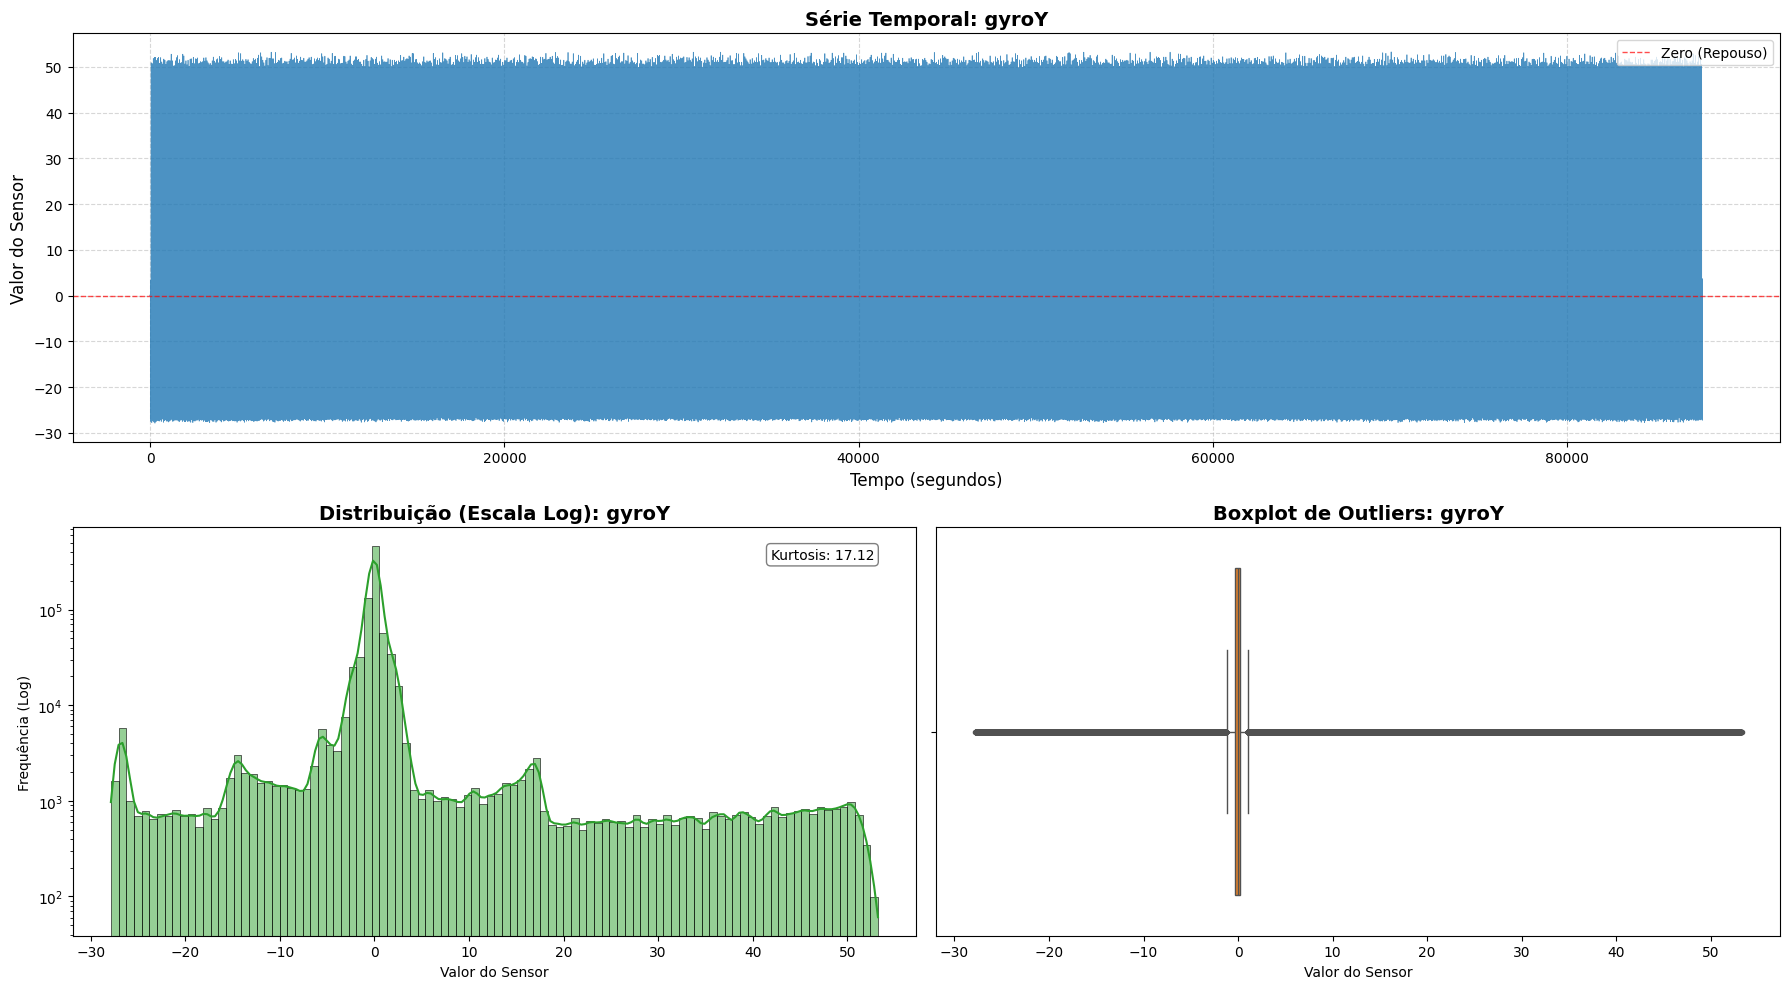

In [19]:
plot_sensor(df, col_sensor='gyroY')

- O boxplot mostra que não deve-se remover os outliers pela regra de desvio padrão (3-sigma), pois serão apagados o movimento do robô sobrando só o ruído dele padrado

## Análise Exploratória Estrutural [Classe Anômala]

# TODO
Montar EDA para faultydf; 
    verificar se gyroY de falha tem picos diferentes
    comparar magZ em df e faultydf (se forem iguais, ele é irrelevante para detecção e pode ser descartado)
    ambos precisam ter a mesma frequência para entrar no modelo
    verificar se possui os mesmos defeitos físicos (jitter, gaps)

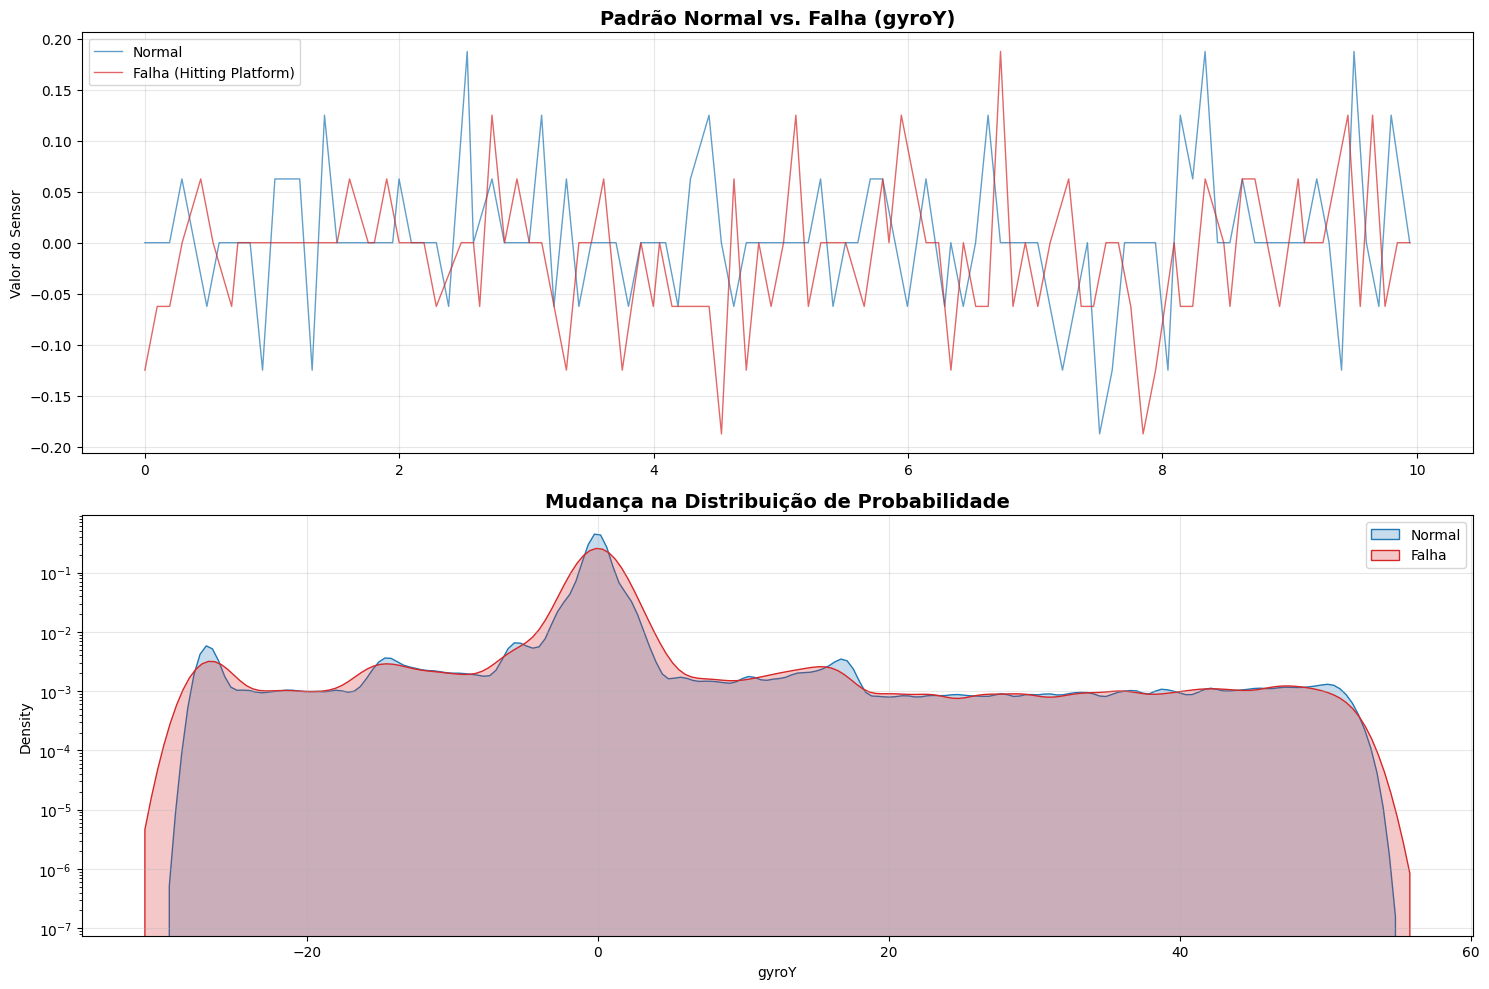

In [23]:
def comparar_normal_vs_falha(df_normal, df_falha, col_sensor='gyroY'):
    """
    Plota comparativo visual entre operação Normal e Falha (Ataque/Colisão).
    """
    # 1. Ajuste de Tempo (reseta para começar do zero em ambos para facilitar visualização)
    t_norm = (df_normal['time'] - df_normal['time'].iloc[0]) / 1e3
    t_fail = (df_falha['time'] - df_falha['time'].iloc[0]) / 1e3
    
    # Recorte: Pegar apenas os primeiros 10 segundos de cada para não poluir
    mask_norm = t_norm <= 10
    mask_fail = t_fail <= 10
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
    
    # --- PLOT 1: COMPARAÇÃO NO TEMPO ---
    # Normal
    axes[0].plot(t_norm[mask_norm], df_normal.loc[mask_norm, col_sensor], 
                 color='#1f77b4', label='Normal', alpha=0.7, linewidth=1)
    axes[0].set_title(f'Padrão Normal vs. Falha ({col_sensor})', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Valor do Sensor')
    axes[0].legend(loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # Falha (mesmo eixo para ver a diferença de magnitude)
    axes[0].plot(t_fail[mask_fail], df_falha.loc[mask_fail, col_sensor], 
                 color='#d62728', label='Falha (Hitting Platform)', alpha=0.7, linewidth=1)
    axes[0].legend()
    
    # --- PLOT 2: COMPARAÇÃO DE DENSIDADE (KDE) ---
    # Mostra se a "forma" dos dados mudou
    sns.kdeplot(df_normal[col_sensor], ax=axes[1], color='#1f77b4', fill=True, label='Normal')
    sns.kdeplot(df_falha[col_sensor], ax=axes[1], color='#d62728', fill=True, label='Falha')
    axes[1].set_title('Mudança na Distribuição de Probabilidade', fontsize=14, fontweight='bold')
    axes[1].set_yscale('log') # Log para ver as caudas
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if 'name' in faultydf.columns: faultydf = faultydf.drop(columns=['name'])

# Execute a comparação
comparar_normal_vs_falha(df, faultydf, col_sensor='gyroY')

# TODO
O que procurar neste novo gráfico:

    Mudança de Amplitude: A linha vermelha (falha) atinge picos muito maiores que 50? (Indicaria impacto forte).

    Mudança de Frequência: A linha vermelha oscila muito mais rápido ou fica "travada" em valores estranhos?

    Deslocamento de Distribuição (Gráfico de baixo): Se a curva vermelha estiver deslocada para a direita ou esquerda em relação à azul, significa que a média mudou (drift). Se a curva vermelha for "mais gorda", a variância (vibração) aumentou.

Essas pistas visuais vão ditar quais features seu modelo precisa (ex: se a amplitude mudou, max/min são boas features. Se a frequência mudou, FFT é melhor).

## Análise de Valores Faltantes e Outliers
- Identificação de valores faltantes e outliers
- Visualizações de apoio, caso necessário
- Análise dos mecanismos


In [22]:
print(f"Quantidade de valores faltantes em df: {df.isnull().sum().sum()}")
print(f"Quantidade de Valores faltantes em faultydf: {faultydf.isnull().sum().sum()}")

Quantidade de valores faltantes em df: 0
Quantidade de Valores faltantes em faultydf: 0


- Não serão removidos os outliers estatísticos pois são movimentos reais

# PREPARAÇÃO DOS DADOS
- Normalização com RobustScaler
- aplicando filtragem Savitzky–Golay para reduzir o ruído dos sensores
- apresentar a quantidade alta de zeros nos sensores causada pelos frequentes momentos de inércia do braço

- Serão mantidos os Zeros, pois representam o estado "Idle/Aguardando"

# TODO
Resampling para df e faultydf

In [27]:
# 1. Converter tempo para Datetime (necessário para resampling)
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df = df.set_index('datetime')

# 2. Resampling para 100ms (10Hz) - Ajuste conforme a média que vimos
# .mean() pega todos os pontos que caíram naquele 0.1s e tira a média (reduz ruído)
df_resampled = df.resample('100ms').mean()

# 3. Verificar onde ficaram os buracos (NaNs gerados pelo resampling)
print(f"Buracos gerados pelo alinhamento: {df_resampled['accX'].isnull().sum()}")

# 4. Preencher buracos com Interpolação Linear
# 'time' garante que a interpolação respeite a distância temporal
df_final = df_resampled.interpolate(method='time')

# 5. Drop nas colunas que não fazem sentido interpolar (ex: label)
# Para label, geralmente usamos 'ffill' (repetir o anterior) ou 'nearest'
if 'label' in df_final.columns:
    df_final['label'] = df_resampled['label'].fillna(method='ffill').astype(int)

print("Resampling concluído. Novo shape:", df_final.shape)

Buracos gerados pelo alinhamento: 44766
Resampling concluído. Novo shape: (876347, 11)


/tmp/ipykernel_44151/3191090216.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final['label'] = df_resampled['label'].fillna(method='ffill').astype(int)


# TODO
Scaler em df

In [ ]:
""" from sklearn.preprocessing import RobustScaler

# 1. Instanciar o Scaler
scaler = RobustScaler()

# 2. FIT (Aprender a escala) -> SÓ NO NORMAL (df)
scaler.fit(df_normal_resampled)

# 3. TRANSFORM (Aplicar a escala) -> df e faultydf
df_normal_scaled = scaler.transform(df_normal_resampled)
df_faulty_scaled = scaler.transform(df_faulty_resampled) """ 

In [ ]:
df.columns,faultydf.columns

cols = ["accX", "accY","accZ","gyroX", "gyroY", "gyroZ", "magX", "magY", "magZ"]


In [ ]:
df.loc[:, cols].describe( #remover time e label
        ).T.style.format("{:.4f}"
        ).background_gradient(cmap="Blues")

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
def plotSensors(dfPlot, step=1,suptitle="SENSORES AO LONGO DE 1 MINUTO\n",startTimeIdx=None,endTimeIdx=None):
    df = dfPlot.iloc[::step]
    fig = plt.figure(figsize=(25, 15))

    if not any((startTimeIdx, endTimeIdx)):
        startTimeIdx,endTimeIdx =  df['time'].iloc[0],df['time'].iloc[-1]
    else:
        startTimeIdx,endTimeIdx =  df['time'].iloc[startTimeIdx],df['time'].iloc[endTimeIdx]

    # Helper to plot three axes in the same subplot
    def plotSensorsSameGraph(ax, cols, title, x="time"):
        for col in cols:
            mask = (df['time'] >= startTimeIdx) & (df['time'] < endTimeIdx)
            ax.plot(df[mask][x], df[mask][col], label=col)

        ax.set_title(title, fontsize=18)
        ax.set_xlabel(x)
        ax.set_ylabel("value")
        ax.legend(loc='lower left')

    # === Subplots ===
    ax1 = fig.add_subplot(3, 1, 1)
    plotSensorsSameGraph(ax1,
                         cols=["accX", "accY","accZ"],
                         title="Accelerometer (X, Y, Z)")

    ax2 = fig.add_subplot(3, 1, 2)
    plotSensorsSameGraph(ax2,
                         cols=["gyroZ","gyroX", "gyroY", ],
                         title="Gyroscope (X, Y, Z)")

    ax3 = fig.add_subplot(3, 1, 3)
    plotSensorsSameGraph(ax3,
                         cols=["magZ", "magY", "magX"],
                         title="Magnetometer (X, Y, Z)")
    plt.suptitle(suptitle, fontsize='18')
    plt.tight_layout()
    plt.show()
plotSensors(df,startTimeIdx=20050, endTimeIdx=20050 + 60*10)
plotSensors(df,suptitle="SENSORES")

In [ ]:
from scipy.signal import savgol_filter
# Savitzky-golay, um filtro bom pra series temporais (inspirado por https://www.nixtla.io/blog/polynomial_filtering)
for col in cols:
  df[col + "_smooth"] = savgol_filter(df[col], window_length=8, polyorder=2)


In [ ]:
sensor_groups = [
    ("Accelerometer", ["accX", "accY", "accZ"]),
    ("Gyroscope", ["gyroX", "gyroY", "gyroZ"]),
    ("Magnetometer", ["magX", "magY", "magZ"])
]
def plot_raw_vs_smooth(df,step=10):
    fig, axes = plt.subplots(3, 3, figsize=(32, 24))
    df = df.iloc[::step]

    for row, (title, cols) in enumerate(sensor_groups):
        for col, axis in enumerate(cols):
            ax = axes[row][col]

            raw = df[axis]
            smooth = df[axis + "_smooth"]

            ax.plot(df["time"], raw, label="raw", alpha=0.35)
            ax.plot(df["time"], smooth, label="smooth", linewidth=2)

            ax.set_title(f"{title} — {axis}", fontsize=16)
            ax.set_xlabel("time")
            ax.set_ylabel("value")
            ax.legend()

    plt.tight_layout()
    plt.show()
plot_raw_vs_smooth(df)

## Comparação antes e depois da filtragem

1. adicionar a imagem aqui porque é muito lento pra calcular)

1. Adicionar metricas de ruído


## Normalização dos sinais com z-score

In [ ]:
means = df[cols].mean()
stds = df[cols].std()

for col in cols:
    df[col + "_norm"] = (df[col] - means[col]) / stds[col]
    faultydf[col + "_norm"] = (faultydf[col] - means[col]) / stds[col]

In [ ]:
def plot_raw_vs_normalized(dfPlot, step=10):
    fig, axes = plt.subplots(3, 3, figsize=(40, 16))
    df = dfPlot.iloc[::step]

    for row, (title, cols) in enumerate(sensor_groups):
        for col, axis in enumerate(cols):
            ax = axes[row][col]

            raw = df[axis]
            norm = df[axis + "_norm"]

            ax.plot(df["time"], raw, label="raw", alpha=0.35)
            ax.plot(df["time"], norm, label="normalized", linewidth=2)

            ax.set_title(f"{title} - {axis}", fontsize=16)
            ax.set_xlabel("time")
            ax.set_ylabel("value")
            ax.legend()


    plt.tight_layout()
    plt.show()

In [ ]:
plot_raw_vs_normalized(df)